In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine          # any tabular data will do
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [3]:
wine = load_wine(as_frame=True)
X_raw = wine.data                               # 178 × 13 numeric features
y_true = wine.target                            # for reference only
print("Raw shape:", X_raw.shape)

Raw shape: (178, 13)


In [4]:
# ------------------------------------------------------------------
# 2. Standardize (mean 0, variance 1) — distances are scale‑sensitive
# ------------------------------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

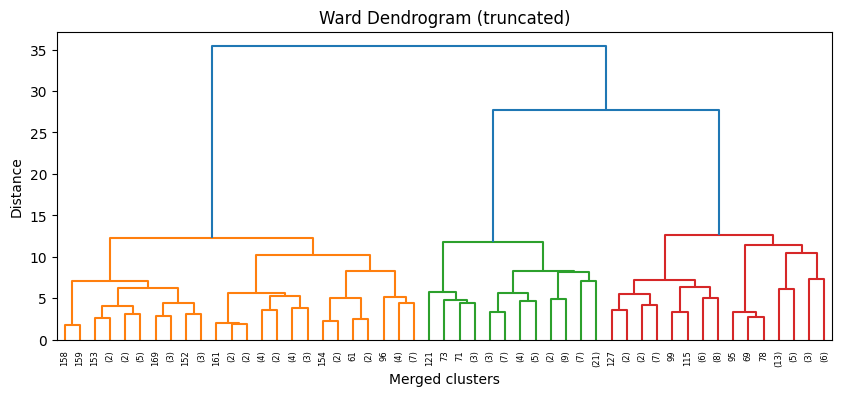

/var/folders/lg/43zch9_d6bxbxfxqp055yfr80000gn/T/ipykernel_96691/3400643521.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


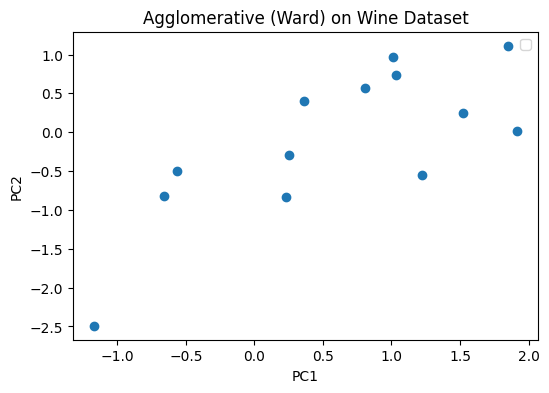

In [7]:
# ------------------------------------------------------------------
# 3. Build the linkage matrix with SciPy for the dendrogram
#    (Ward linkage is variance‑minimizing & works well on Euclidean)
# ------------------------------------------------------------------
Z = linkage(X, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    truncate_mode="level",     # show only the last p merges for clarity
    p=5,
    show_leaf_counts=True,
)
plt.title("Ward Dendrogram (truncated)")
plt.xlabel("Merged clusters")
plt.ylabel("Distance")
plt.show()


plt.figure(figsize=(6, 4))

plt.scatter(X[0], X[1])
plt.title(f"Agglomerative (Ward) on Wine Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [7]:
# ------------------------------------------------------------------
# 4. Decide how many clusters.
#    • Option A: eyeball the dendrogram and set n_clusters
#    • Option B: iterate on n_clusters, use silhouette score
# ------------------------------------------------------------------
def silhouette_for_k(k: int) -> float:
    model = AgglomerativeClustering(
        n_clusters=k, linkage="ward", metric="euclidean"
    )
    labels = model.fit_predict(X)
    return silhouette_score(X, labels)

scores = {k: silhouette_for_k(k) for k in range(2, 11)}
best_k = max(scores, key=scores.get)
print("Silhouette by k:", scores)
print("Best k =", best_k, "→ silhouette =", scores[best_k])

Silhouette by k: {2: np.float64(0.26701317712722306), 3: np.float64(0.2774439826952266), 4: np.float64(0.225836659334758), 5: np.float64(0.18674235566758707), 6: np.float64(0.17966642854438503), 7: np.float64(0.18685342560226942), 8: np.float64(0.18834697102837825), 9: np.float64(0.1917169293227209), 10: np.float64(0.19856750165505588)}
Best k = 3 → silhouette = 0.2774439826952266


/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in mat

In [8]:
# ------------------------------------------------------------------
# 5. Fit final model with best_k (and optionally compare linkages)
# ------------------------------------------------------------------
linkages = ["ward", "complete", "average", "single"]
models = {}
for lnk in linkages:
    model = AgglomerativeClustering(
        n_clusters=best_k, linkage=lnk, metric="euclidean"
    )
    labels = model.fit_predict(X)
    models[lnk] = (model, labels, silhouette_score(X, labels))

# Display silhouettes for each linkage
for lnk, (_, _, sc) in models.items():
    print(f"{lnk:>8} linkage → silhouette {sc:.3f}")

# Choose Ward (or whichever is highest) for downstream analysis
final_labels = models["ward"][1]

    ward linkage → silhouette 0.277
complete linkage → silhouette 0.204
 average linkage → silhouette 0.158
  single linkage → silhouette 0.183


/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in mat

In [9]:
# ------------------------------------------------------------------
# 6. Attach cluster labels back to a DataFrame for profiling
# ------------------------------------------------------------------
df = X_raw.copy()
df["cluster"] = final_labels
print(df.groupby("cluster").mean().round(2).T.head())  # peek at feature means


cluster                0      1       2
alcohol            12.20  13.06   13.67
malic_acid          1.94   3.17    1.97
ash                 2.22   2.41    2.46
alcalinity_of_ash  20.21  21.00   17.53
magnesium          92.55  99.86  106.16


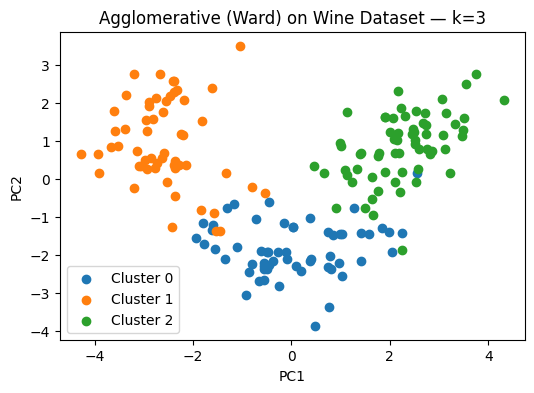

In [10]:
# ------------------------------------------------------------------
# 7. Visualize clusters with PCA (optional helper—2‑D projection)
# ------------------------------------------------------------------
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 4))
for lbl in np.unique(final_labels):
    mask = final_labels == lbl
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Cluster {lbl}")
plt.title(f"Agglomerative (Ward) on Wine Dataset — k={best_k}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()